# Previsão de Preços com LSTM
Este notebook utiliza dados históricos de ações para treinar uma rede neural LSTM e prever preços futuros.

In [1]:

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

plt.style.use('fivethirtyeight')


## 1. Carregar os Dados e Pré-processamento

In [8]:

# Carregar os dados
df = pd.read_csv('sp500_stocks_final.csv')

# Converter coluna 'Date' para datetime
df['Date'] = pd.to_datetime(df['Date'])

# Filtrar os dados para a ação 'MMM' e intervalo de datas
mmm_data = df[df['Symbol'] == 'MMM']
mmm_data = mmm_data.sort_values(by='Date')

# Definir o intervalo de datas
start_date = mmm_data['Date'].min()
end_date = mmm_data[mmm_data['Date'].dt.year == 2023]['Date'].max()

# Filtrar os dados de acordo com o intervalo
mmm_filtered = mmm_data[(mmm_data['Date'] >= start_date) & (mmm_data['Date'] <= end_date)]

# Selecionar preços de fechamento
mmm_close = mmm_data[['Date', 'Close']]

# Salvar os dados de fechamento para inspeção futura
mmm_close.to_csv('mmm_close_only.csv', index=False)

# Converter os valores da coluna "Close" para um array NumPy
close_prices = mmm_close['Close'].values

# Divisão dos dados em treino e teste
train_data_length = int(len(close_prices) * 0.8)  # 80% para treino
train_data = close_prices[:train_data_length]
test_data = close_prices[train_data_length:]

# Escalar os dados para o intervalo [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices.reshape(-1, 1))

# Preparação dos dados de treino com janela de 60 dias
x_train_scaled, y_train_scaled = [], []

for i in range(60, train_data_length):
    x_train_scaled.append(scaled_data[i-60:i, 0])  # Últimos 60 dias
    y_train_scaled.append(scaled_data[i, 0])  # Próximo dia

x_train_scaled = np.array(x_train_scaled)
y_train_scaled = np.array(y_train_scaled)

# Reshape para LSTM: [amostras, timesteps, features]
x_train_scaled = x_train_scaled.reshape(x_train_scaled.shape[0], x_train_scaled.shape[1], 1)


In [12]:
print(f"Dimensões do mmm_data: {mmm_filtered.shape}")


Dimensões do mmm_data: (3522, 8)


## 2. Construção e Treinamento do Modelo LSTM

In [3]:

# Construção do modelo LSTM
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train_scaled.shape[1], 1)))
model.add(Dropout(0.4))  # Dropout para evitar overfitting
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(50, activation='relu'))  # Camada densa intermediária
model.add(Dense(1))  # Camada de saída

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo com validação
history = model.fit(
    x_train_scaled, y_train_scaled,
    epochs=50,
    batch_size=32,
    validation_split=0.2,  # Separar 20% para validação
    verbose=1
)


c:\Users\rafae\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0361 - val_loss: 8.9175e-04
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0031 - val_loss: 0.0010
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0016 - val_loss: 7.9857e-04
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0018 - val_loss: 7.9824e-04
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0017 - val_loss: 7.2717e-04
Epoch 9/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0013 - val_loss: 8.1577e-04
Epoch 10/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0012 - val_loss: 8.4132e-04
Epoch 11/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0011 - val_loss: 7.1028e-04
Epoch 12/50
74/74 ━━━━━━━━━━━━━━━━━

## 3. Visualização do Histórico de Perda

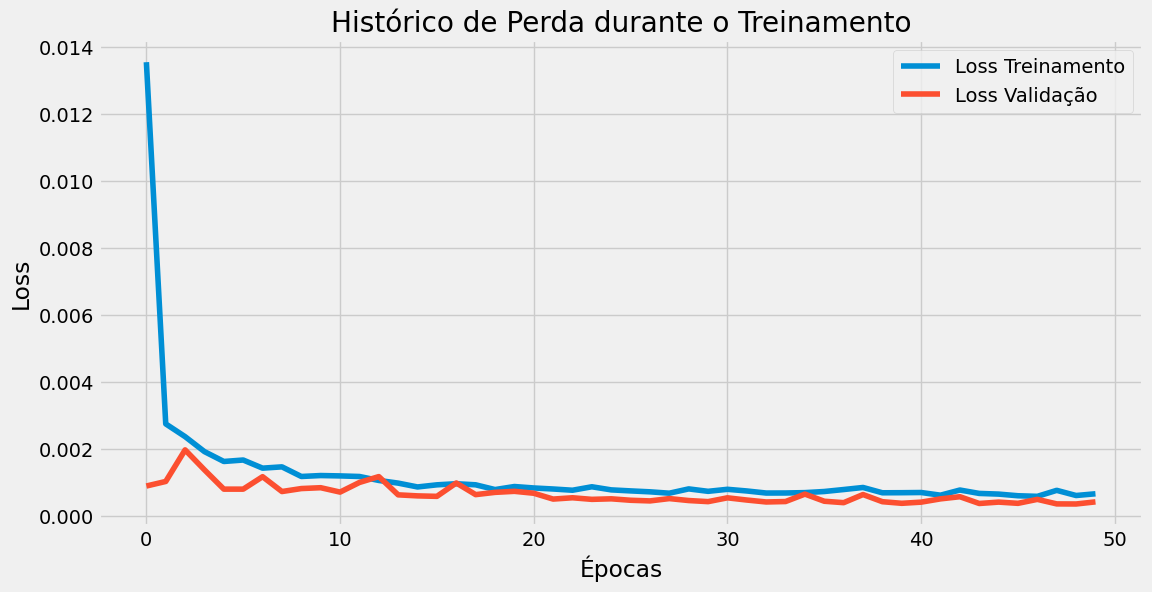

In [4]:

# Visualizar histórico de perda (train vs validation)
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Loss Treinamento')
plt.plot(history.history['val_loss'], label='Loss Validação')
plt.title('Histórico de Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()


## 4. Avaliação no Conjunto de Teste

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
RMSE: 2.9694351138449586
MAPE: 0.02204269583071095


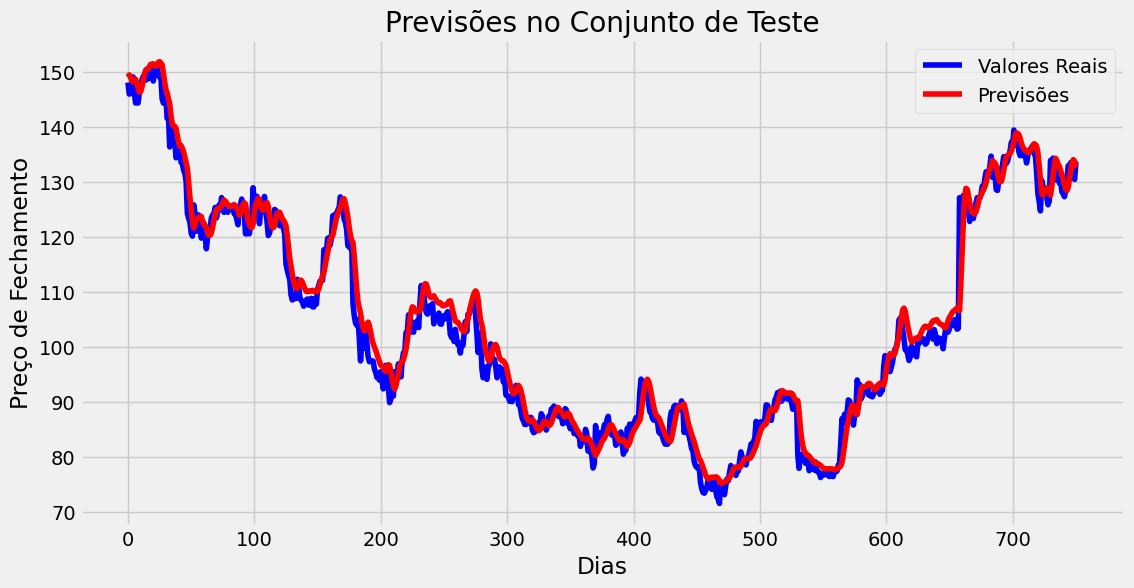

In [5]:

# Preparação dos dados de teste
test_scaled = scaled_data[train_data_length - 60:, :]

# Criar conjuntos de teste
x_test_scaled = []
y_test = close_prices[train_data_length:]

for i in range(60, len(test_scaled)):
    x_test_scaled.append(test_scaled[i-60:i, 0])

x_test_scaled = np.array(x_test_scaled)
x_test_scaled = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[1], 1)

# Previsões no conjunto de teste
preds = model.predict(x_test_scaled)
preds = scaler.inverse_transform(preds)  # Reverter o escalonamento

# Avaliar o desempenho
rmse = np.sqrt(mean_squared_error(y_test, preds))
mape = mean_absolute_percentage_error(y_test, preds)
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

# Visualizar as previsões no conjunto de teste
plt.figure(figsize=(12, 6))
plt.plot(y_test, color='blue', label='Valores Reais')
plt.plot(preds, color='red', label='Previsões')
plt.title('Previsões no Conjunto de Teste')
plt.xlabel('Dias')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()


## 5. Previsões para Janeiro de 2024

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━

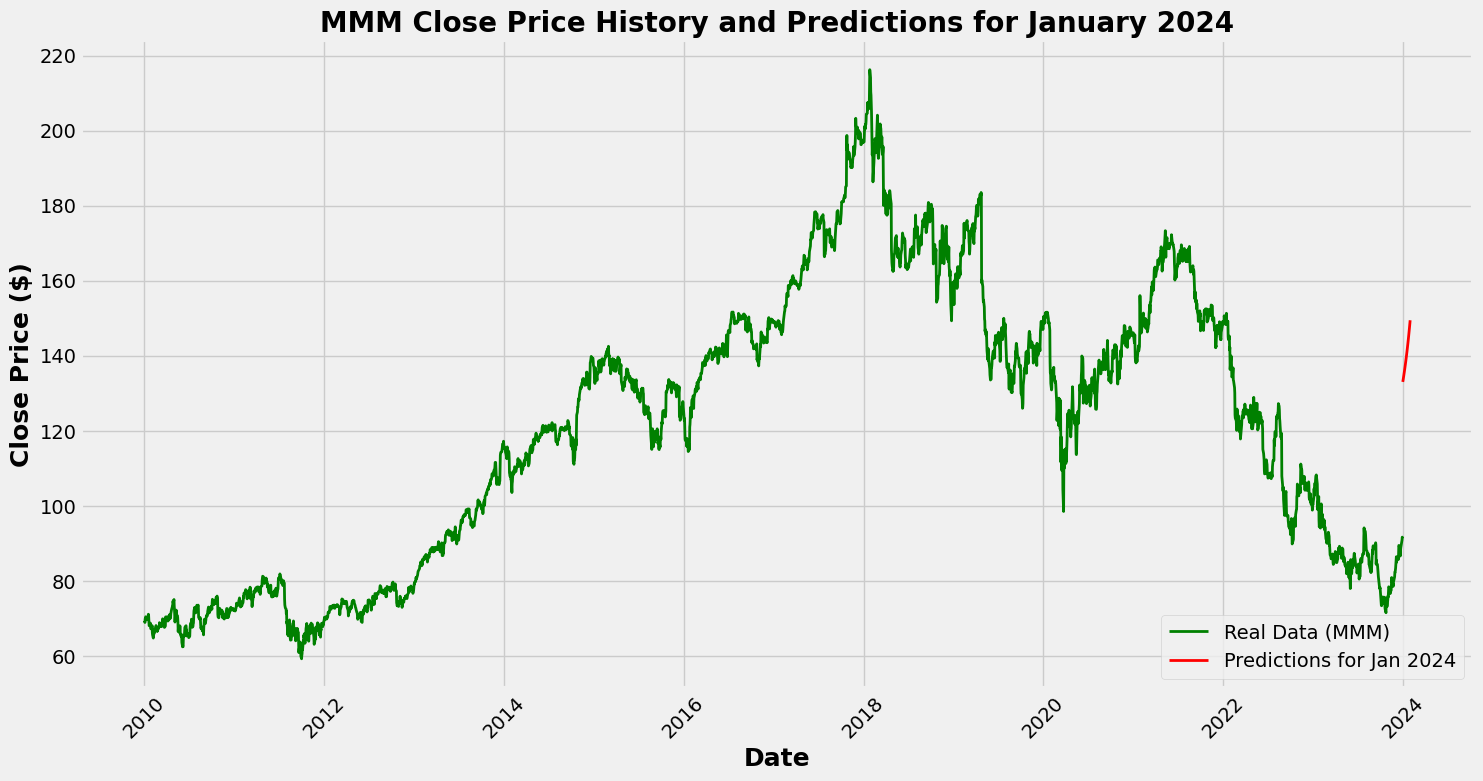

Previsões de Janeiro de 2024 salvas em 'janeiro_2024_previsoes.csv'.


In [9]:
# Prever janeiro de 2024
future_predictions = []
current_input = test_scaled[-60:]  # Últimos 60 dias conhecidos

for _ in range(31):  # Prever 31 dias
    prediction = model.predict(current_input.reshape(1, 60, 1))
    future_predictions.append(prediction[0, 0])
    current_input = np.append(current_input[1:], prediction, axis=0)  # Atualizar entrada

# Reverter o escalonamento para os valores previstos
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Preparar as datas para o conjunto de previsões
last_date = mmm_filtered['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=31)

# Criar DataFrame para os valores previstos
predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predictions': future_predictions.flatten()
})

# Plotar os resultados
plt.figure(figsize=(16, 8))
plt.title('MMM Close Price History and Predictions for January 2024', fontweight='bold', fontsize=20)
plt.xlabel('Date', fontsize=18, fontweight='bold')
plt.ylabel('Close Price ($)', fontsize=18, fontweight='bold')

# Plotando os dados reais até 2023 (verde)
plt.plot(mmm_filtered['Date'], mmm_filtered['Close'], color='green', label='Real Data (MMM)', linewidth=2)

# Plotando as previsões para janeiro de 2024 (vermelho)
plt.plot(predictions_df['Date'], predictions_df['Predictions'], color='red', label='Predictions for Jan 2024', linewidth=2)

# Adicionar legenda
plt.legend(loc='lower right')

# Rotacionar as datas no eixo X
plt.xticks(rotation=45)

# Exibir o gráfico
plt.show()

# Salvar as previsões em arquivo
predictions_df.to_csv('janeiro_2024_previsoes.csv', index=False)
print("Previsões de Janeiro de 2024 salvas em 'janeiro_2024_previsoes.csv'.")
